# Train different Neural Networks on a Traffic Sign Detection Dataset

In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
import os
from enum import Enum
from abc import ABC, abstractmethod
from typing import Optional
import random
import numpy as np
from PIL import Image
import yaml

In [2]:
class DataType(Enum):
    TRAIN = 1
    TEST = 2
    VALID = 3

class Label:
    def __init__(self, raw_data: str) -> None:
        split_data = raw_data.split(' ')
        self.category = int(split_data[0])
        self.center_x, self.center_y, self.width, self.height = map(float, split_data[1:])

class Entry:
    def __init__(self, image: np.array, labels: list[Label], image_name: str) -> None:
        self.image = image
        self.labels = labels
        self.image_name = image_name


dataset_path = 'data/traffic-signs-detection'
info_file = os.path.join(dataset_path, 'car/data.yaml')
categories = yaml.load(open(info_file), Loader=yaml.FullLoader)['names']

img_size = 128
min_bounding_box_size = 0.2
only_single_label = True
forbidden_file_prefixes = ['FisheyeCamera', 'road']
grayscale = False

def load_image_data(type: DataType):
    data_path = os.path.join(dataset_path, 'car', type.name.lower())
    images_path = os.path.join(data_path, 'images')
    labels_path = os.path.join(data_path, 'labels')

    entries = []
    files_in_folder = os.listdir(images_path)
    print(f'Scanning {len(files_in_folder)} entries from {images_path} and {labels_path}...')

    for image_name in files_in_folder:
        image = plt.imread(os.path.join(images_path, image_name))
        image = np.array(Image.fromarray(image).resize((img_size, img_size)))

        if grayscale:
            image = np.mean(image, axis=2)
        
        image = image / 255.0
        labels_raw = open(os.path.join(labels_path, image_name.replace('.jpg', '.txt'))).read().split('\n')
        labels = [Label(label) for label in labels_raw if label]

        if (
            only_single_label and len(labels) > 1
            or len(labels) == 0
            or any([image_name.startswith(prefix) for prefix in forbidden_file_prefixes])
            or any([label.width < min_bounding_box_size or label.height < min_bounding_box_size for label in labels])
        ):
            continue

        entries.append(Entry(image, labels, image_name))

    return entries

train_data = load_image_data(DataType.TRAIN)
validate_data = load_image_data(DataType.VALID)
test_data = load_image_data(DataType.TEST)

print(f'Loaded {len(train_data)} training images, {len(validate_data)} validation images and {len(test_data)} test images')

Scanning 3530 entries from data/traffic-signs-detection/car/train/images and data/traffic-signs-detection/car/train/labels...
Scanning 801 entries from data/traffic-signs-detection/car/valid/images and data/traffic-signs-detection/car/valid/labels...
Scanning 638 entries from data/traffic-signs-detection/car/test/images and data/traffic-signs-detection/car/test/labels...
Loaded 1939 training images, 493 validation images and 335 test images


Displaying 6 random images from each of the following categories: Green Light, Speed Limit 100, Speed Limit 90, Stop


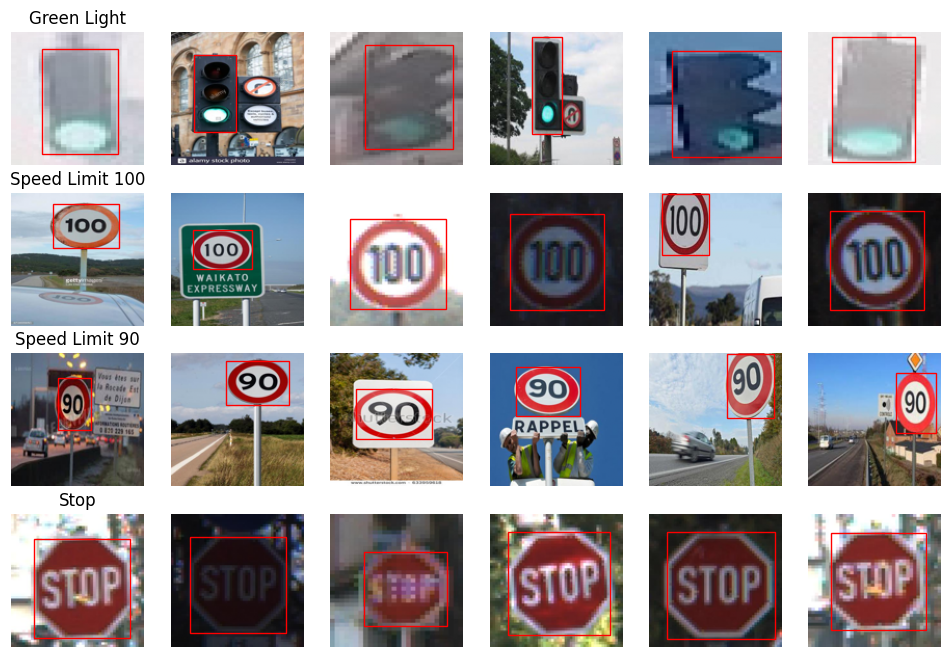

In [3]:
num_images = 6
categories_to_display = [0, 3, 13, 14]
fig, axs = plt.subplots(len(categories_to_display), num_images, figsize=(num_images * 2, len(categories_to_display) * 2))
print(f'Displaying {num_images} random images from each of the following categories: {", ".join([categories[category] for category in categories_to_display])}')

for idx, category in enumerate(categories_to_display):
    category_entries = [entry for entry in validate_data if entry.labels[0].category == category]
    
    if len(category_entries) >= num_images:
        selected_entries = random.sample(category_entries, num_images)
    else:
        selected_entries = category_entries
    
    for i, entry in enumerate(selected_entries):
        axs[idx, i].imshow(entry.image, cmap='gray')
        axs[idx, i].axis('off')
        if i == 0:
            axs[idx, i].set_title(categories[category])
            
        for label in entry.labels:
            x = label.center_x * img_size
            y = label.center_y * img_size
            w = label.width * img_size
            h = label.height * img_size
            rect = plt.Rectangle((x - w / 2, y - h / 2), w, h, fill=False, color='r')
            axs[idx, i].add_patch(rect)

for ax in axs.flat:
    ax.axis('off')

plt.show()


In [4]:
import keras_tuner as kt
from keras import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

def get_data(data: list[Entry]):
    images = np.array([entry.image for entry in data])
    labels = to_categorical(np.array([entry.labels[0].category for entry in data]), num_classes=len(categories))
    return images, labels

def build_model(hp):
    model = Sequential()
    
    model.add(Input(shape=(img_size, img_size, 3)))
    model.add(Flatten())
    
    num_layers = hp.Int('num_layers', 1, 5)
    
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        model.add(Dense(units=units, activation='relu'))
        
        if hp.Boolean(f'dropout_{i}'):
            dropout_rate = hp.Float(f'dropout_rate_{i}', 0.1, 0.5)
            model.add(Dropout(rate=dropout_rate))
    
    model.add(Dense(len(categories), activation='softmax'))
    learning_rate = hp.Float('learning_rate', 1e-5, 1e-2, sampling='LOG')
    
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='models',
    project_name='dense_model_tuning'
)

train_images, train_labels = get_data(train_data)
validate_images, validate_labels = get_data(validate_data)

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(train_images, train_labels, validation_data=(validate_images, validate_labels),
             epochs=10, batch_size=32, callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")

best_model = tuner.hypermodel.build(best_hps)

best_model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_data=(validate_images, validate_labels))

Trial 16 Complete [00h 00m 08s]

Best val_accuracy So Far: 0.456389456987381
Total elapsed time: 06h 04m 16s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
5                 |1                 |num_layers
192               |320               |units_0
True              |False             |dropout_0
0.00128           |1.2972e-05        |learning_rate
0.17482           |0.22633           |dropout_rate_0
320               |96                |units_1
False             |True              |dropout_1
448               |416               |units_2
False             |False             |dropout_2
256               |448               |units_3
True              |False             |dropout_3
32                |288               |units_4
True              |True              |dropout_4
0.13702           |0.43256           |dropout_rate_1
0.19808           |0.13981           |dropout_rate_2
0.30891           |0.46474           |dropout_rate_3
4                 |4       

Traceback (most recent call last):
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^

RuntimeError: Can't decrement id ref count (file write failed: time = Thu Jan  9 07:19:18 2025
, filename = 'models/dense_model_tuning/trial_0016/checkpoint.weights.h5', file descriptor = 65, errno = 28, error message = 'No space left on device', buf = 0x55c59cf0, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 0)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Thu Jan  9 07:19:18 2025
, filename = 'models/dense_model_tuning/trial_0016/checkpoint.weights.h5', file descriptor = 65, errno = 28, error message = 'No space left on device', buf = 0x55c59cf0, total write size = 2048, bytes this sub-write = 2048, bytes actually written = 18446744073709551615, offset = 0)


RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 76, in on_epoch_end
    self._save_model()
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 86, in _save_model
    self.model.save_weights(write_filepath)
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/h5py/_hl/group.py", line 483, in __setitem__
    ds = self.create_dataset(None, data=obj)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/h5py/_hl/group.py", line 183, in create_dataset
    dsid = dataset.make_new_dset(group, shape, dtype, data, name, **kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/enniobinder/ai-research/myenv/lib/python3.11/site-packages/h5py/_hl/dataset.py", line 168, in make_new_dset
    dset_id.write(h5s.ALL, h5s.ALL, data)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5d.pyx", line 281, in h5py.h5d.DatasetID.write
  File "h5py/_proxy.pyx", line 115, in h5py._proxy.dset_rw
OSError: [Errno 28] Can't synchronously write data (file write failed: time = Thu Jan  9 07:19:18 2025
, filename = 'models/dense_model_tuning/trial_0016/checkpoint.weights.h5', file descriptor = 65, errno = 28, error message = 'No space left on device', buf = 0x7fcd7f8b7520, total write size = 22268656, bytes this sub-write = 22268656, bytes actually written = 18446744073709551615, offset = 0)


In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.optimizers import Adam

# create model
model = Sequential()
model.add(Input(shape=(img_size, img_size, 3)))
model.add(Conv2D(1, (8, 8), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
def get_data(data: list[Entry]):
    images = np.array([entry.image for entry in data])
    labels = np.array([entry.labels[0].category for entry in data])
    return images, labels

train_images, train_labels = get_data(train_data)
validate_images, validate_labels = get_data(validate_data)

model.fit(train_images, train_labels, epochs=10, validation_data=(validate_images, validate_labels))

In [5]:
# evaluate model
test_images, test_labels = get_data(test_data)
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5603 - loss: 2.0366
Accuracy: 59.70%


[<Conv2D name=conv2d, built=True>, <MaxPooling2D name=max_pooling2d, built=True>, <Conv2D name=conv2d_1, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dense name=dense_1, built=True>]


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 121, 121, 1)    │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 60, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Text(0.5, 1.0, 'Output of First Layer')

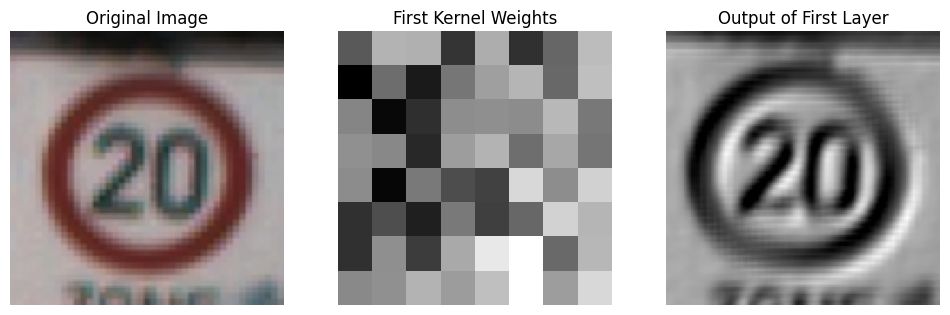

In [6]:
# get the output value of the first layer of the custom model
print(model.layers)

layer_models = []
for i, layer in enumerate(model.layers):
    layer_model = Sequential()
    for j in range(i + 1):
        layer_model.add(model.layers[j])
    layer_models.append(layer_model)

layer_models[1].summary()

# image = train_images[:1]
# print(image.shape)
# layer_models[1].predict(image)

# raise

# while True:
#     # keras expects a batch of images, so we need to add an additional dimension to the image
#     input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
#     layer_output = [layer_model.predict(input_data) for layer_model in layer_models]

#     # the plot should look like this:
#     #                        Layer 1 Filter 1 weights     Layer 1 Output 1       ...       Layer n Filter 1 weights     Layer n Output 1      
#     # Original Image         ...                          ...                    ...       ...                          ...                     Predicted Category
#     #                        Layer 1 Filter n weights     Layer 1 Output n       ...       Layer n Filter n weights     Layer n Output n
#     #

#     fig, ax, plt.subplots()


#     plt.show()

input_data = test_images[np.random.randint(0, len(test_images))][np.newaxis]
layer_output = layer_models[0].predict(input_data)
# plot the original image, the weights of the first kernel and the output of the first layer
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(input_data[0])
axs[0].axis('off')
axs[0].set_title('Original Image')

weights = model.layers[0].get_weights()[0]
weights_min = weights.min()
weights_max = weights.max()
weights = (weights - weights_min) / (weights_max - weights_min)
axs[1].imshow(weights[:, :, 0, 0], cmap='gray')
axs[1].axis('off')
axs[1].set_title('First Kernel Weights')

output = layer_output[0]
axs[2].imshow(output[:, :, 0], cmap='gray')
axs[2].axis('off')
axs[2].set_title('Output of First Layer')


## What happened?
1. I suffered from exploding gradients with HeInitialization() and MeanSquaredError(). I tried gradient clipping to 1.0 but turns out I don't have exploding gradients but vanishing gradients and exploding outputs. The outputs were very high with very low gradients, weird... Possible reasons are MeanSquaredError(), ReLU() and the batch size of 1 leading to instable gradients. Other potential reason: high learning rate.
2. I changed to CrossEntropy() -> still vanishing gradients
3. LeakyReLU() -> still vanishing
4. Used RandomInitialization() and Sigmoid() activation function, works perfectly now

I'm going to try adding batch processing so it will also work, maybe something with my Softmax output function was wrong, I want to try the original architecture (128 64 LeakyReLU, CrossEntropy, Xavier but with a different output activation function to see if the code for Softmax is broken)


